# NRK todo:

~~1) Write function to calculate assembly activation in line with van de Ven and Trouche papers: Rk(t) = z(t)T*pk*z(t).  Make SURE to zero out diagnoal in pk!!!~~
  
~~2) Plot out assembly activation for Marble07 day 2.  ~~

~~3) Compare to previous method, directly multiplying the ica weight * PSAbool.~~

~~4) Figure out why ICAs are so similar for this method - plot out zproj, PCmats (Zproj_cov), etc. and compare between Marble07 day 1 and 2.  Is it because ICA is not converging? Or for some other reason?~~

~~5) Play around with FastICA params: random_state, n_iters, tol, etc...~~

~~6) Tidy up parameters ued for running this method. Make dictionary for PCA, ICA, and Lopes dos Santos (call it dupret?).  should have both pca and ica params for dupret, e.g. `params['dupret']['pca']['whiten'] = False`, `params['dupret']['pca']['whiten'] = True`~~


In [1]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import pandas as pd

In [2]:
# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

from session_directory import find_eraser_directory as get_dir
import er_plot_functions as erp
import Placefields as pf
import freezing_analysis as fa
import helpers 
import eraser_reference as err

# Project save directory here
print_dir = '/Users/nkinsky/Documents/BU/Working/Eraser/plots'

First, run some sanity checks on your outputs - do you see blatant differences in outputs like covariance matrices for Marble07 day 1 (few freezing ensembles) vs day 2?  As a reminder, Day 2 has tons of freeze related ensembles whereas Day 1 has relative few.

In [3]:
DR1 = fa.DimReduction('Marble07', 'Shock', 1, ica_method='ica_on_cov', whiten=False)  
DR2 = fa.DimReduction('Marble07', 'Shock', 2, ica_method='ica_on_cov', whiten=False)

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Calculating Dupret activations from raw calcium activity


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Calculating Dupret activations from raw calcium activity


In [4]:
# _ = DR1.plot_rasters(dr_type='dupret', y2scale=0.3)
# _ = DR2.plot_rasters(dr_type='dupret', y2scale=0.3)

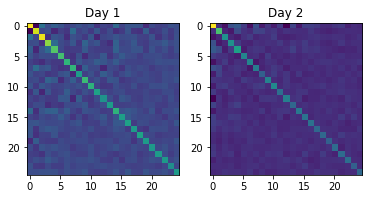

In [5]:
fig, ax = plt.subplots(1,2)
for a, DR in zip(ax, [DR1, DR2]):
    a.imshow(DR.cov_zproj)
    a.set_title('Day ' + str(DR.day))
    

Ok, super interesting.  Much less variability in PCs on day 2 than day 1, which might be why I'm getting such different results!  Check out distribution of weights - are they the same?  Also, try plotting the above with the diagonal zeroed out.  (Does the method have you do that???)

One possibility is that I am supposed to apply the ICA method to the Zproj matrix, not the `cov_zproj` as shown above.  Let's give that a shot.

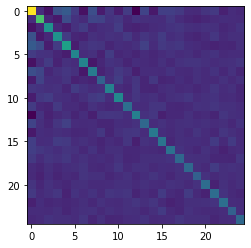

In [6]:
fig, ax = plt.subplots()
ax.imshow(np.cov(DR.zproj))

Text(0.5, 1.0, 'W mat: ICA onto cov(Zproj)')

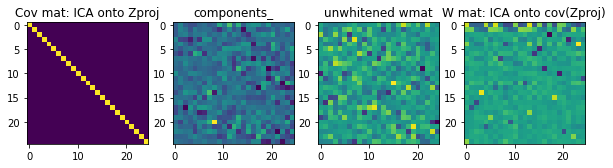

In [7]:
from sklearn.decomposition import FastICA, PCA
ICAtransformer = FastICA(whiten=True)
zica = ICAtransformer.fit_transform(DR.zproj.T).T
w = np.dot(ICAtransformer.components_, np.linalg.inv(ICAtransformer.whitening_))

fig, ax = plt.subplots(1,4)
fig.set_size_inches((10, 5))
ax[0].imshow(np.cov(zica))
ax[0].set_title('Cov mat: ICA onto Zproj')
ax[1].imshow(ICAtransformer.components_)
ax[1].set_title('components_')
ax[2].imshow(w)
ax[2].set_title('unwhitened wmat')
ax[3].imshow(DR.w_mat)
ax[3].set_title('W mat: ICA onto cov(Zproj)')

In [8]:
fig.get_size_inches()

array([10.,  5.])

Ok, so the first method (not yet implemented) seems to be doing a much better job of separating things than the method I used.  This is MOST LIKELY because the original method used (ICA on PCA-projected covariance matrix) is NOT CORRECT.

However, this also hints that, on some days, we might be ending up with redundant freezing assemblies using the incorrect method because the PC(s) associated with freezing have much larger weights than others. So, it could be very interesting to assess and track the highest PC weight of the freeze-related ensemble across days...

For now, let's check our work re-running the above with the new method.

BIG QUESTION: Do I need to whiten the data while running ICA (whiten=True), or leave it alone (whiten=False).  I think True is correct since cov_zproj is not the identity matrix (although it is pretty close...).

In [9]:
DR1z = fa.DimReduction('Marble07', 'Shock', 1, ica_method='ica_on_zproj', whiten=True, random_state=1)
DR2z = fa.DimReduction('Marble07', 'Shock', 2, ica_method='ica_on_zproj', whiten=True, random_state=1)

Calculating Dupret activations from raw calcium activity
Calculating Dupret activations from raw calcium activity


Grabbing pre-calculated Dupret activations for raw data
Grabbing pre-calculated Dupret activations for raw data


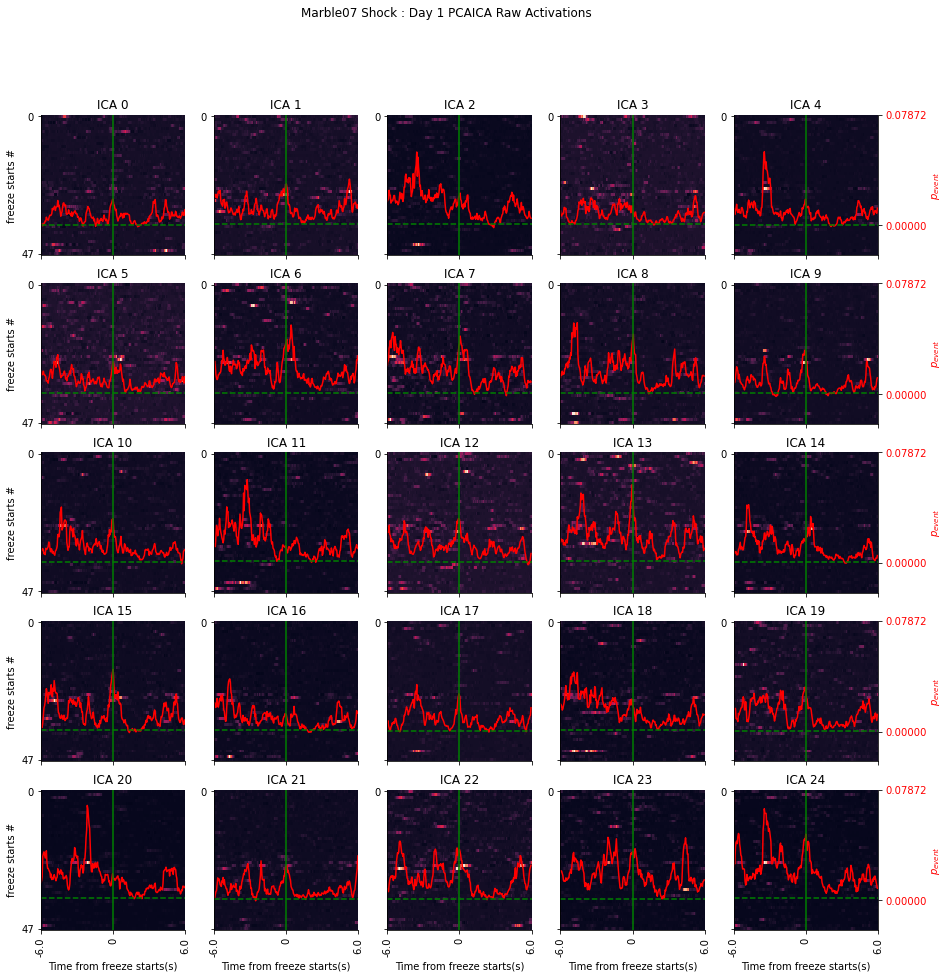

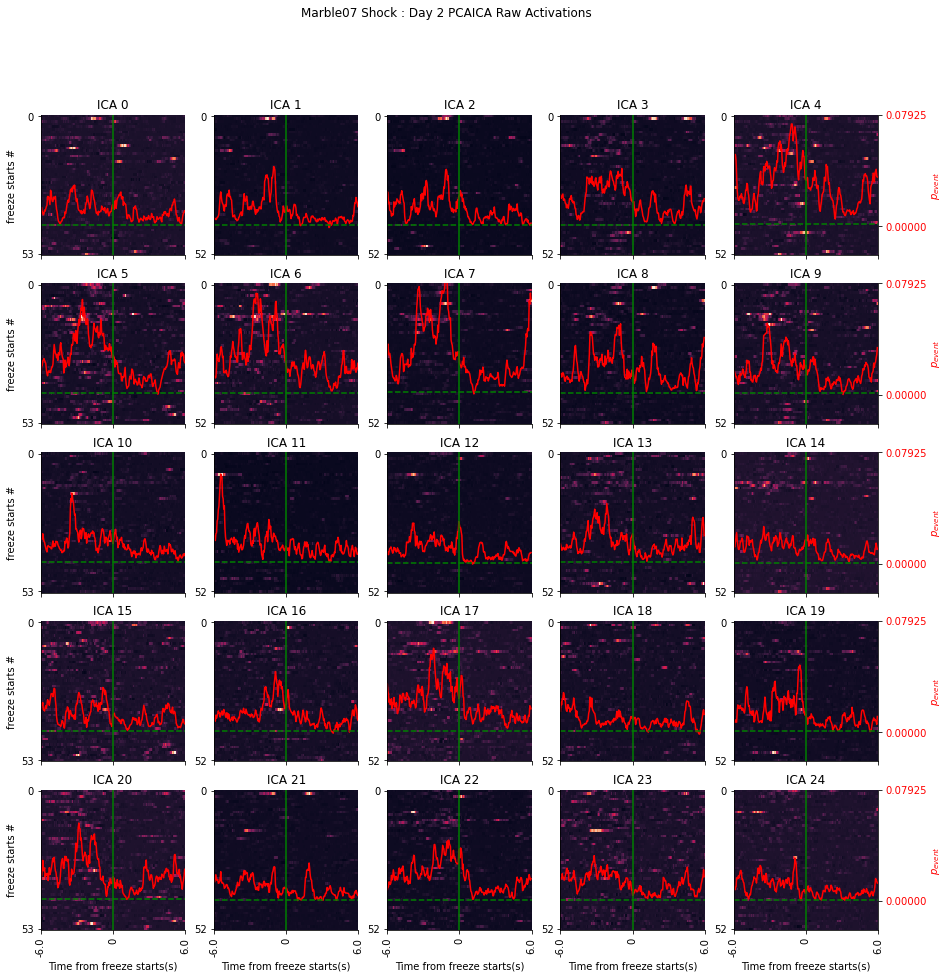

In [10]:
%matplotlib inline
_ = DR1z.plot_rasters(dr_type='pcaica', y2scale=0.1)
_ = DR2z.plot_rasters(dr_type='pcaica', y2scale=0.1)

Calculating Dupret activations from raw calcium activity


<IPython.core.display.Javascript object>


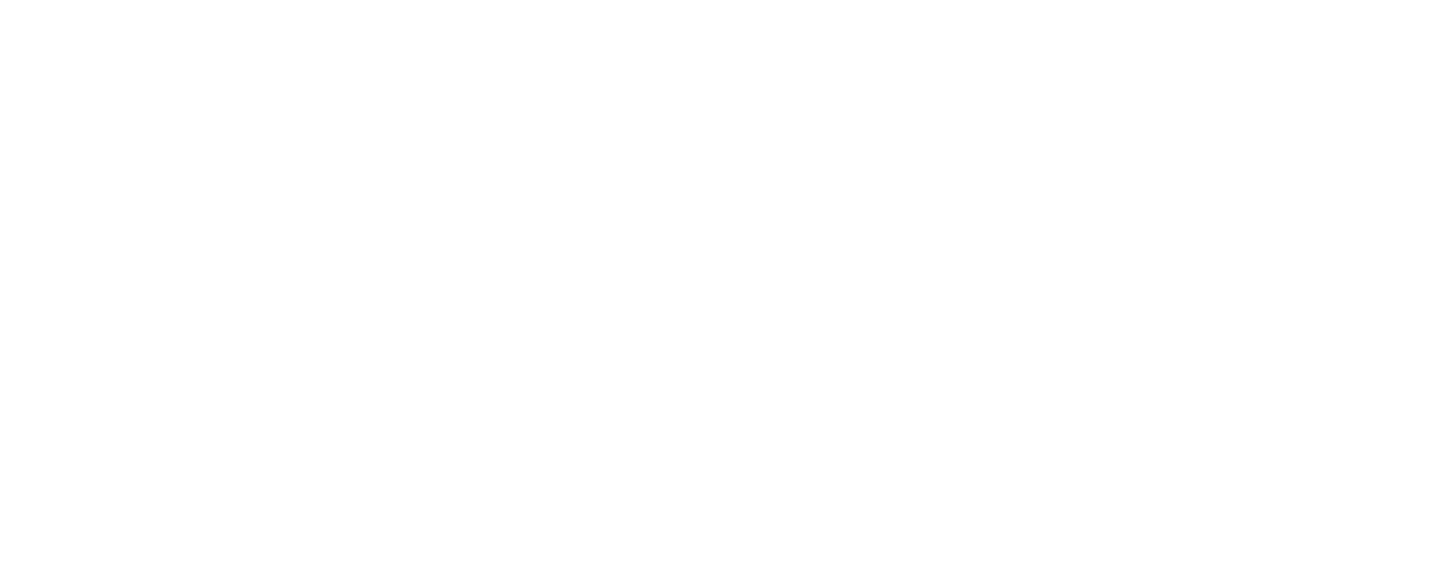

In [11]:
# Get activations for Shock Day 2 and plot similar looking activations overlaid on one another 
# to make sure they are independent

%matplotlib notebook

activations = DR2z.get_activations(dr_type='dupret', psa_use='raw')

freeze_ensembles = [0, 1, 4, 12]  # just chosen by eye from above
non_freeze_ensembles = [17, 23]

fig, axover = plt.subplots(figsize=(10,4))
t = np.arange(activations.shape[1])/DR.PF.sr_image
[axover.plot(t, act) for act in activations[freeze_ensembles]]  # plot freezing ensembles
axover.plot(t, activations[freeze_ensembles].mean(axis=0), 'k-')
for freeze_start, freeze_end in zip(DR.freeze_starts, DR.freeze_ends):
    axover.axvspan(freeze_start, freeze_end)

Grabbing pre-calculated Dupret activations for raw data


<IPython.core.display.Javascript object>


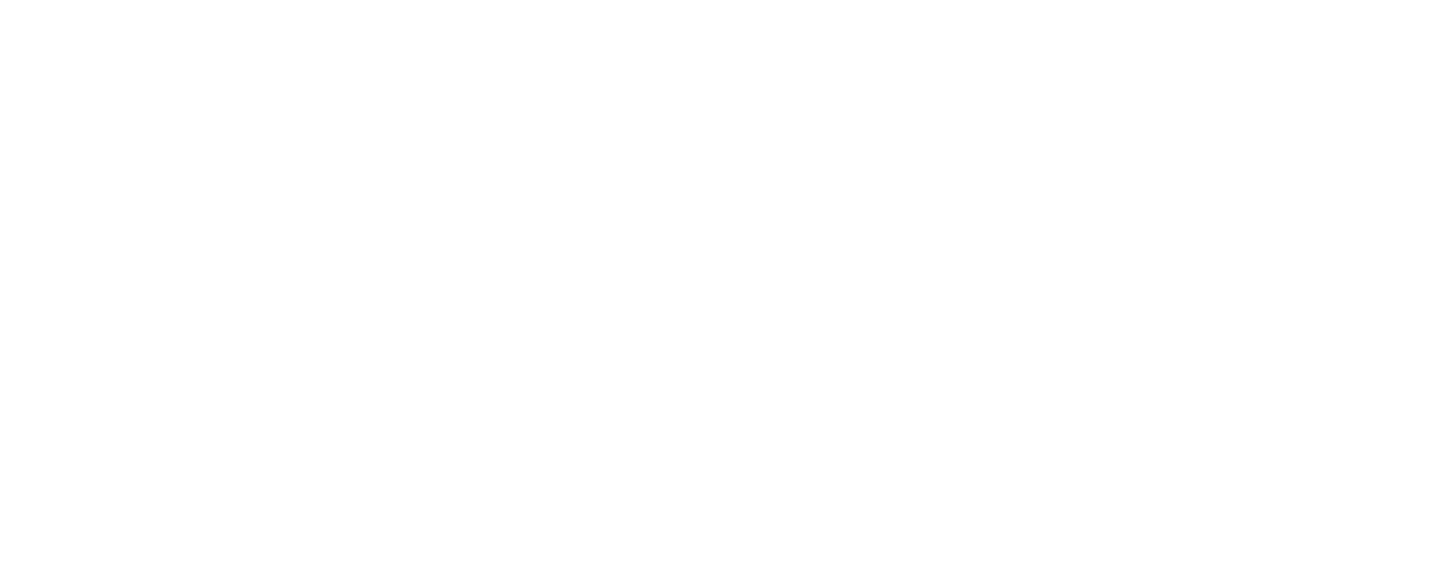

In [12]:
# Plot non freeze tuned ensemble activations here



%matplotlib notebook

activations = DR2z.get_activations(dr_type='dupret', psa_use='raw')

freeze_ensembles = [0, 1, 4, 12]  # just chosen by eye from above
non_freeze_ensembles = [17, 23]

fig, axover = plt.subplots(figsize=(10,4))
t = np.arange(activations.shape[1])/DR.PF.sr_image
[axover.plot(t, act) for act in activations[non_freeze_ensembles]]  # plot freezing ensembles
hf, = axover.plot(t, activations[freeze_ensembles].mean(axis=0), 'k-')  # Plo avg freezing ensemble in black
hnf, = axover.plot(t, activations[non_freeze_ensembles].mean(axis=0), 'r--')  # Plo avg non-freezing ensemble in black
for freeze_start, freeze_end in zip(DR.freeze_starts, DR.freeze_ends):
    axover.axvspan(freeze_start, freeze_end)
axover.legend((hf, hnf), ('Freeze avg', 'Non-freeze avg'))

# Now look at PCA for freezing ensembles
maybe this simplifies things? Less freezing ensembles?

Calculating Dupret activations from raw calcium activity


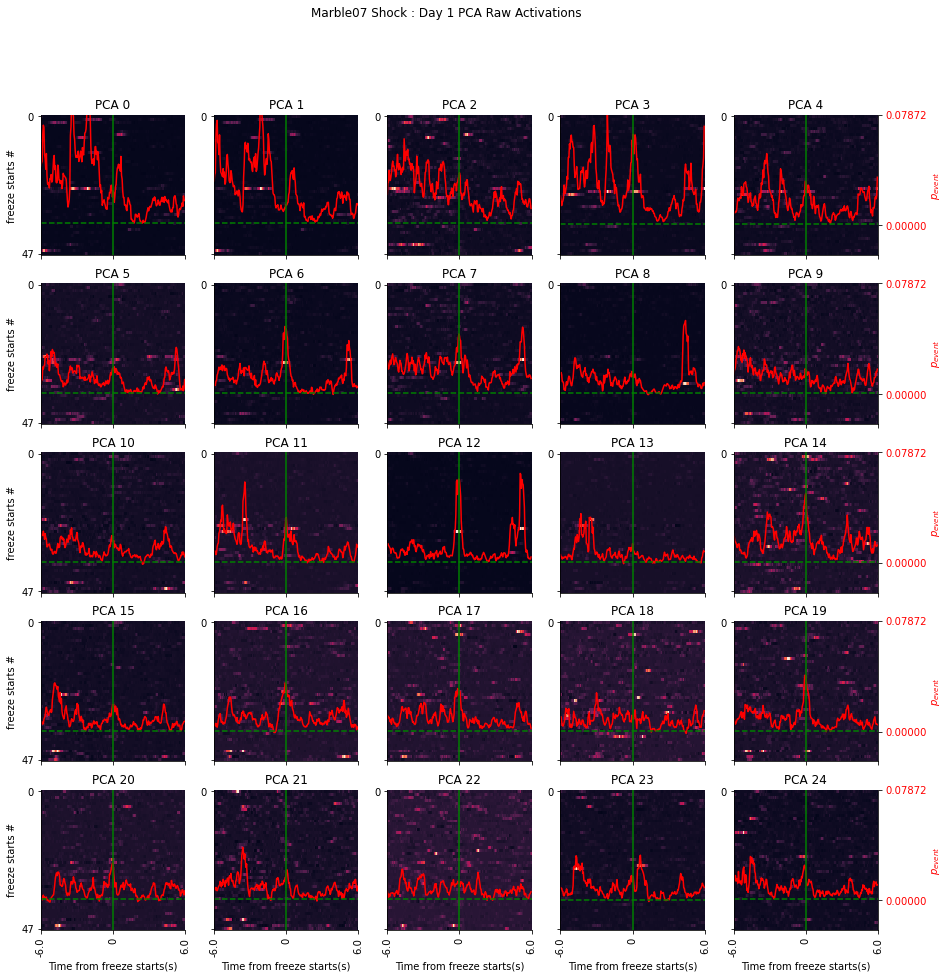

In [13]:
%matplotlib inline
_ = DR1z.plot_rasters(dr_type='pca', y2scale=0.1)
# _ = DR2z.plot_rasters(dr_type='pca', y2scale=0.3)

Grabbing pre-calculated Dupret activations for raw data


<AxesSubplot:>

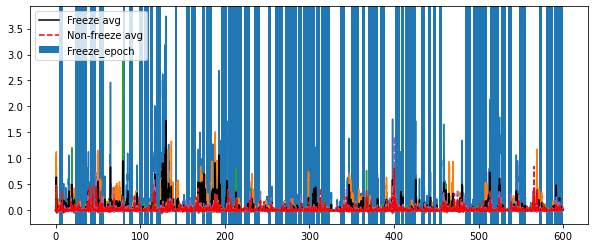

In [14]:
# Plot non freeze tuned ensemble activations here

DR2z.plot_activations_w_freezing(dr_type='pca', freeze_ensembles=[0, 1, 13], non_freeze_ensembles=[18, 22])

# %matplotlib notebook

# activations = DR2z.calc_dupret_activations(psa_use='raw', dr_type='pca')

# freeze_ensembles = [0, 4]  # just chosen by eye from above
# non_freeze_ensembles = [21, 23]

# fig, axover = plt.subplots(figsize=(10,4))
# t = np.arange(activations.shape[1])/DR.PF.sr_image
# [axover.plot(t, act) for act in activations[non_freeze_ensembles]]  # plot freezing ensembles
# hf, = axover.plot(t, activations[freeze_ensembles].mean(axis=0), 'k-')  # Plo avg freezing ensemble in black
# hnf, = axover.plot(t, activations[non_freeze_ensembles].mean(axis=0), 'r--')  # Plo avg non-freezing ensemble in black
# for freeze_start, freeze_end in zip(DR.freeze_starts, DR.freeze_ends):
#     axover.axvspan(freeze_start, freeze_end)
# axover.legend((hf, hnf), ('Freeze avg', 'Non-freeze avg'))

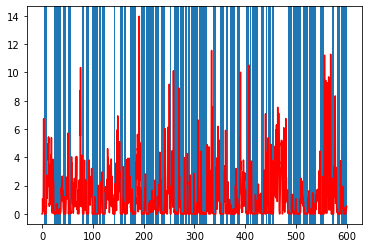

In [15]:
_, ax10 = plt.subplots()
ax10.plot(t, DR2z.PF.speed_sm, 'r')
for freeze_start, freeze_end in zip(DR2z.freeze_starts, DR2z.freeze_ends):
    ax10.axvspan(freeze_start, freeze_end)


Now, simulate a perfect "freeze onset" cell that has a bump of activity peaking 1 second before each freezing epoch.

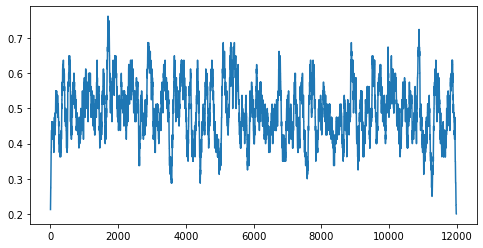

In [16]:
from scipy.ndimage import gaussian_filter1d
nframes = DR2z.PF.PSAbool_align.shape[1]
prand = np.random.poisson(0.5, nframes)
# pr_filt = gaussian_filter1d(prand, sigma=2)
pr_filt = np.convolve(prand, np.ones(80), 'same')/80

_, axp = plt.subplots(figsize=(8,4))
# axp.plot(prand)
axp.plot(pr_filt)

In [17]:
def plot_xcorr(activity, speed, time_buffer_sec, sr, axcorr, label, labelx=True):
    maxlags = np.round(time_buffer_sec*sr).astype('int')
    axcorr.xcorr(activity, speed, maxlags=maxlags)
    axcorr.set_xticks([-maxlags, 0, maxlags])
    axcorr.axvline(0, color='k')
    axcorr.set_xticklabels([str(-time_buffer_sec), "0", str(time_buffer_sec)])
    axcorr.set_title(label)
    if labelx:
        axcorr.set_xlabel('Lag (s)')
    axcorr.set_ylabel('Cross-Corr.')
    
    axcorr.autoscale(enable=True, axis='x', tight=True)  # Make it plot to very ends
    sns.despine(ax=axcorr)

In [18]:
print(DR2z.freeze_starts[7])
DR2z.freeze_ends[6]

104.11


103.84

Grabbing pre-calculated Dupret activations for raw data


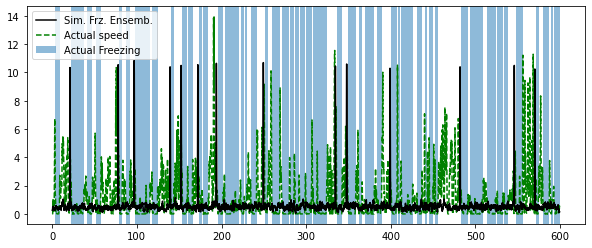

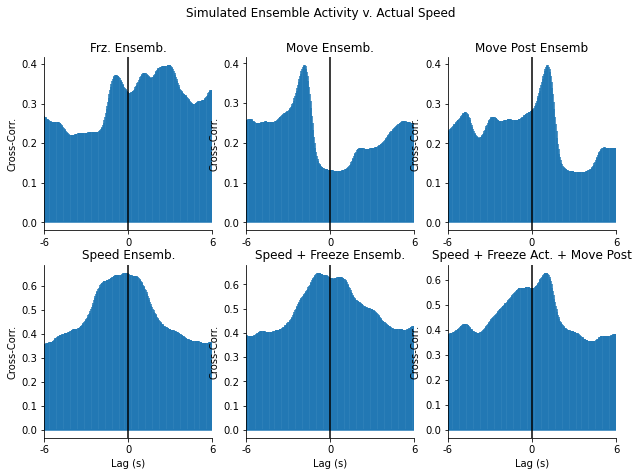

In [24]:
nframes = DR2z.PF.PSAbool_align.shape[1]
speed = DR2z.PF.speed_sm
connect_bouts = True # True = don't simulate freezing activity for a quick wiggle between two longs freezing bouts

# Pre-allocate with some noise
noise_width = 20
prand = np.random.poisson(0.5, nframes)
freeze_act_sim = np.zeros_like(DR2z.get_activations(dr_type='pcaica')[0]) + np.convolve(prand, np.ones(noise_width), 'same')/noise_width
move_act_sim = np.zeros_like(freeze_act_sim) + np.convolve(prand, np.ones(noise_width), 'same')/noise_width
move_post_sim = np.zeros_like(freeze_act_sim) + np.convolve(prand, np.ones(noise_width), 'same')/noise_width

act_bump = np.sin(np.arange(21)/20*np.pi)*10  # Make a one second bump of activity

# Simulate data - 
for idf, (freeze_start, freeze_end) in enumerate(zip(DR2z.freeze_starts, DR2z.freeze_ends)):
    freeze_ind = np.round(freeze_start*DR2z.PF.sr_image).astype('int')
    move_ind = np.round(freeze_end*DR2z.PF.sr_image).astype('int')
    if connect_bouts:
        if idf > 0 and (freeze_start - DR2z.freeze_ends[idf - 1]) > 6:
            freeze_act_sim[(freeze_ind - 40) : (freeze_ind - 19)] = act_bump + freeze_act_sim[(freeze_ind - 40) : (freeze_ind - 19)] 
    elif not connect_bouts:
        freeze_act_sim[(freeze_ind - 40) : (freeze_ind - 19)] = act_bump + freeze_act_sim[(freeze_ind - 40) : (freeze_ind - 19)] 
    move_act_sim[(move_ind - 40) : (move_ind - 19)] = act_bump + move_act_sim[(move_ind - 40) : (move_ind - 19)]
    if move_ind < (nframes - 41):
        move_post_sim[(move_ind + 19) : (move_ind + 40)] = act_bump + move_post_sim[(move_ind + 19) : (move_ind + 40)]

# Not the best speed-related simulation - should probably be that the poisson value goes up for higher speeds!  
speed_lead_sim = np.convolve(np.roll(speed, int(-DR2z.PF.sr_image/2)), np.ones(80), 'same')/80
speed_lead_sim = np.random.poisson(speed_lead_sim, nframes)
speed_and_freeze_act_sim = speed_lead_sim + freeze_act_sim
speed_and_freeze_motion_act_sim = speed_lead_sim + freeze_act_sim + move_post_sim

_, axsim = plt.subplots(figsize=(10, 4))
hspeed, = axsim.plot(t, DR2z.PF.speed_sm, 'g--')
hsim, = axsim.plot(t, freeze_act_sim, 'k')
for freeze_start, freeze_end in zip(DR2z.freeze_starts, DR2z.freeze_ends):
    hfreeze = axsim.axvspan(freeze_start, freeze_end, alpha=0.5)
axsim.legend((hsim, hspeed, hfreeze), ('Sim. Frz. Ensemb.', 'Actual speed', 'Actual Freezing'))

figcorr, axcorr = plt.subplots(2, 3, figsize=(10.25, 7))
figcorr.suptitle('Simulated Ensemble Activity v. Actual Speed')
time_buffer_sec = 6
plot_xcorr(freeze_act_sim, speed, time_buffer_sec, DR2z.PF.sr_image, axcorr[0][0], 'Frz. Ensemb.', labelx=False)
plot_xcorr(move_act_sim, speed, time_buffer_sec, DR2z.PF.sr_image, axcorr[0][1], 'Move Ensemb.', labelx=False)
plot_xcorr(move_post_sim, speed, time_buffer_sec, DR2z.PF.sr_image, axcorr[0][2], 'Move Post Ensemb', labelx=False)
plot_xcorr(speed_lead_sim, speed, time_buffer_sec, DR2z.PF.sr_image, axcorr[1][0], 'Speed Ensemb.')
plot_xcorr(speed_and_freeze_act_sim, speed, time_buffer_sec, DR2z.PF.sr_image, axcorr[1][1], 'Speed + Freeze Ensemb.')
plot_xcorr(speed_and_freeze_motion_act_sim, speed, time_buffer_sec, DR2z.PF.sr_image, axcorr[1][2], 'Speed + Freeze Act. + Move Post')


Grabbing pre-calculated Dupret activations for raw data


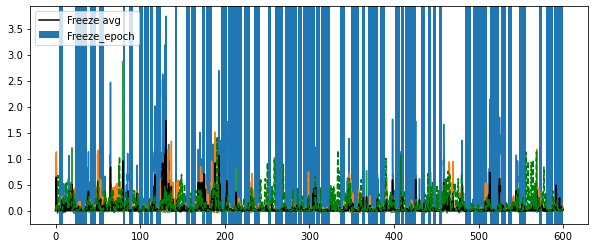

In [25]:
axover = DR2z.plot_activations_w_freezing(dr_type='pca', freeze_ensembles=[0, 1, 13])
nframes = DR2z.PF.PSAbool_align.shape[1]
t = np.arange(nframes)/DR2z.PF.sr_image
axover.plot(t, DR2z.PF.speed_sm/10, 'g--')

Plot x-correlation between each ensemble and speed maybe to check that it is not just a speed tuned cell?

Grabbing pre-calculated Dupret activations for raw data


<IPython.core.display.Javascript object>


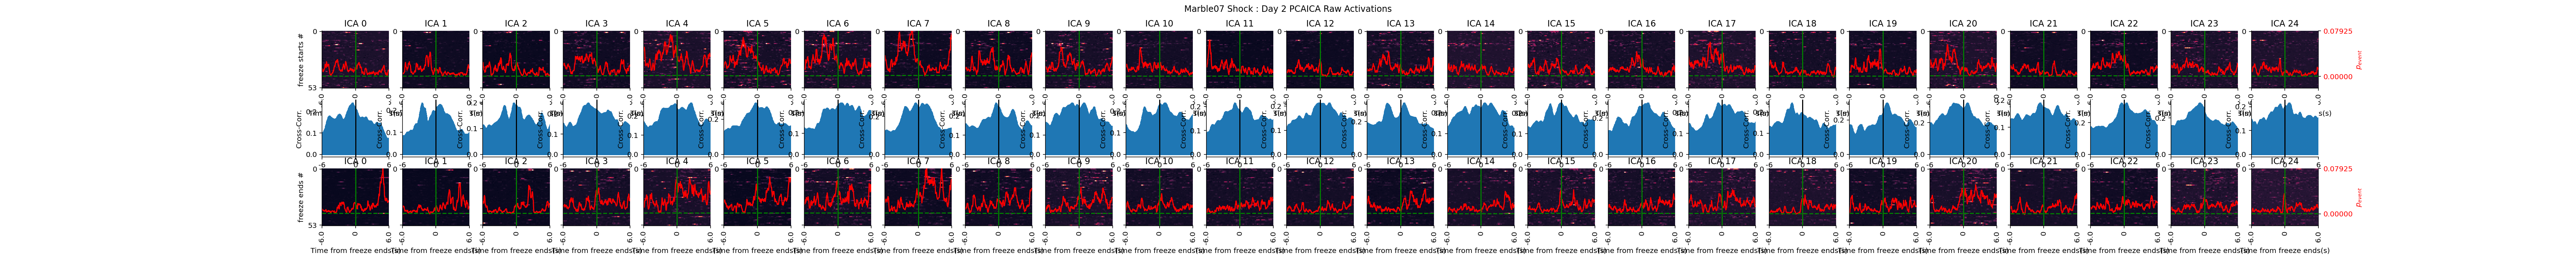

Grabbing pre-calculated Dupret activations for raw data
Grabbing pre-calculated Dupret activations for raw data


In [26]:
%matplotlib notebook
time_buffer_sec = 6
dr_type='pcaica'
activations = DR2z.get_activations(dr_type=dr_type)
speed = DR2z.PF.speed_sm
nact = activations.shape[0]
fig, ax3 = plt.subplots(3, nact, figsize=(50, 5))
DR2z.plot_rasters(dr_type=dr_type, ax=ax3[0, :].reshape(1, nact), y2scale=0.1, buffer=time_buffer_sec)
DR2z.plot_rasters(dr_type=dr_type, ax=ax3[2, :].reshape(1, nact), y2scale=0.1, events='freeze_ends', 
                  buffer=time_buffer_sec)

for a, act in zip(ax3[1, :], activations):
    plot_xcorr(act, speed, time_buffer_sec, DR2z.PF.sr_image, a, '', labelx=False)
    sns.despine(ax=a)
    

In [27]:
# Start tracking ensembles across days!

In [28]:
import placefield_stability as pfs
neuron_map = pfs.get_neuronmap(DR2z.mouse, DR2z.arena, DR2z.day, DR1z.arena, DR1z.day, batch_map_use=True)
nneuronsb = DR1z.df.shape[0]
nics = DR2z.df.shape[1] - 1
weights = np.ones(nneuronsb)*np.nan
valid_map_bool = neuron_map > 0
weights[neuron_map[valid_map_bool]] = DR2z.df[13].copy()[valid_map_bool] 

In [29]:
DR2z.df.values[:, 1:].shape

(466, 25)

In [30]:
# This should work for assigning ic weights across days
weights_full = np.ones((nneuronsb, nics))*np.nan
for icweights, weights1 in zip(weights_full.T, DR2z.df.values[:, 1:].T.copy()):
    icweights[neuron_map[valid_map_bool]] = weights1[valid_map_bool] 

398
161
161


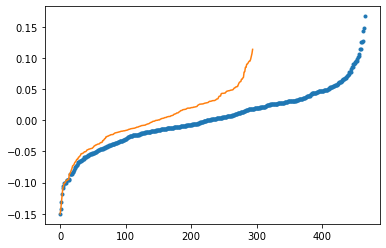

In [31]:
# Check mapping is working correctly
maxwt2_ind = np.where(DR2z.df[13] == np.nanmax(weights))[0][0]
print(maxwt2_ind)
maxwt2_ind_reg = np.nanargmax(weights)
print(maxwt2_ind_reg)
print(neuron_map[398])
%matplotlib inline
fig5, ax5 = plt.subplots(figsize=(6,4))
ax5.plot(DR2z.df[13][DR2z.df[13].argsort()].values,'.')
ax5.plot(np.sort(weights[np.bitwise_not(np.isnan(weights))]))

In [32]:
# Now make pmat and calculate dupret activations for ensembles tracked across days
v2 = DR2z.scale_weights(weights_full)
pmat_custom = DR2z.calc_pmat(v2)

In [33]:
# Check to make sure scaling is working
v2b = v2.copy()
v2b[np.isnan(v2b)] = 0
np.linalg.norm(v2b, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

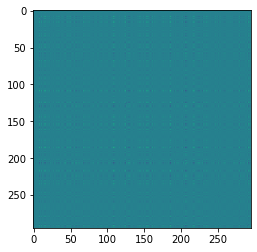

In [34]:
# Plot weight mat
ic_plot = 0
_, ax4 = plt.subplots(figsize=(6,4))
pplot = pmat_custom[ic_plot].copy()

# Keep only rows that are validly mapped between sessions
invalid_bool = np.all(np.bitwise_or(np.isnan(pplot), pplot == 0), axis=0)
valid_bool = np.bitwise_not(invalid_bool)
nvalid = valid_bool.sum()
pplot = pplot[np.outer(valid_bool, valid_bool)].reshape(nvalid, nvalid)
ax4.imshow(pplot)


# NRK to do:

~~0) Do I need to separate unmixing and whitening matrix from the ICA output? I think so!!!~~

~~0.5) Scale v mat weights to have unit length!~~

~~0.75) Check bs_rate plotting in plot_rasters - seems way too low, always at 0 for some reason!~~ - OK, is correct

~~1) Plot out activations over time to check if truly independent AND if related to freezing.~~

2) Assess statistics of assembly activations - are they significantly above chance around freezing? Use same shuffle method as for single cells. Any way to assess reliability, or is the shuffle test sufficient?

3) Clean up code! Initialize and save Dupret activations with psa type at the get-go, save to dictionary maybe so you can adjust later? Write function to check if they are already in dict and quickly plot if they aren't...
# Start with 3 - check that plot_rasters method is working!

4) Create QC notebook or code for each animal/session - plot out cov mat, w mat, a couple activations overlaid, and rasters with stats.

5) Look for negatively modulated cells/ensembles too?

# Todo top of list!
!!! Dump dupret activations into a dictionary with dr_type and psa_type for easy access, e.g.:
`self.dupret_activations['pca']['raw']`

1) Steve noticed that some of these ensembles that are tuned to freeze starts seem to also activate prior to motion onset.  Look at this too!